# Notes 

- Looks like Karpathy doesn't like hockeystick-shaped losses
  - He suggets to put away the 'easy part'

- He actually states **explicitly**, that 'this is something to look up for any NN you might train and something to look up for':
  1. Loss at the initialization is what we expect
  2. Loss curve doesn't look like a hockeystick

## Experiment flow

First, lets

# Init

In [1]:
import lovely_tensors as lt
lt.monkey_patch()

In [2]:
import torch
from torch import nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import os

from PIL import Image
from torchvision.transforms import Resize, Compose, ToTensor, Normalize
import numpy as np
import skimage
import matplotlib.pyplot as plt

import time

def get_mgrid(sidelen, dim=2):
    '''Generates a flattened grid of (x,y,...) coordinates in a range of -1 to 1.
    sidelen: int
    dim: int'''
    tensors = tuple(dim * [torch.linspace(-1, 1, steps=sidelen)])
    mgrid = torch.stack(torch.meshgrid(*tensors), dim=-1)
    mgrid = mgrid.reshape(-1, dim)
    return mgrid

In [3]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [4]:
class UberLayer(nn.Module):
    def __init__(self, input_dim, h=32):
        super().__init__()
        self.linear = nn.Linear(input_dim, h*4)
        self.h = h
        
    def forward(self, x):
        h = self.h
        o = self.linear(x)
        o = o[..., :h].sigmoid() * o[..., h:2*h].tanh() * o[..., 2*h:3*h].sin() * o[..., 3*h:4*h].cos()
        return o


class UberNet(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
  
        self.net += [UberLayer(in_features, hidden_features)]
        self.net += [UberLayer(hidden_features, hidden_features) for _ in range(hidden_layers)]
        self.net += [UberLayer(hidden_features, out_features)]
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords
    
    
# ! pip install random-fourier-features-pytorch
import rff
class UberNetWithEncoding(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, encoded_size, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
  
        self.net += [UberLayer(encoded_size*2, hidden_features)]
        self.net += [UberLayer(hidden_features, hidden_features) for _ in range(hidden_layers)]
        self.net += [UberLayer(hidden_features, out_features)]
        
        self.net = nn.Sequential(*self.net)
        
        self.encoding = rff.layers.GaussianEncoding(sigma=10.0, input_size=2, encoded_size=encoded_size)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        i = self.encoding(coords)
        output = self.net(i)
        return output, coords    

In [5]:
def laplace(y, x):
    grad = gradient(y, x)
    return divergence(grad, x)


def divergence(y, x):
    div = 0.
    for i in range(y.shape[-1]):
        div += torch.autograd.grad(y[..., i], x, torch.ones_like(y[..., i]), create_graph=True)[0][..., i:i+1]
    return div


def gradient(y, x, grad_outputs=None):
    if grad_outputs is None:
        grad_outputs = torch.ones_like(y)
    grad = torch.autograd.grad(y, [x], grad_outputs=grad_outputs, create_graph=True)[0]
    return grad

In [6]:
try:
    from prettytable import PrettyTable
except:
    ! pip install -q prettytable
    from prettytable import PrettyTable

def count_parameters(model):
    table = PrettyTable(["Modules", "Parameters"])
    total_params = 0
    for name, parameter in model.named_parameters():
        if not parameter.requires_grad: continue
        params = parameter.numel()
        table.add_row([name, params])
        total_params+=params
    print(table)
    print(f"Total Trainable Params: {total_params} type {type(model)}")
    return total_params

In [7]:
def get_cameraman_tensor(sidelength):
    pil_img = Image.fromarray(skimage.data.camera())        
    transform = Compose([
        Resize(sidelength),
        ToTensor(),
        Normalize(torch.Tensor([0.5]), torch.Tensor([0.5]))
    ])
    img = transform(pil_img)
    return img, pil_img

In [8]:
class ImageFitting(Dataset):
    def __init__(self, sidelength):
        super().__init__()
        img, pil_img = get_cameraman_tensor(sidelength)
        self.pixels = img.permute(1, 2, 0).view(-1, 1)
        self.coords = get_mgrid(sidelength, 2)
        self.pil_img = pil_img

    def __len__(self):
        return 1

    def __getitem__(self, idx):    
        if idx > 0: raise IndexError
        return self.coords, self.pixels

In [9]:
import os
import random
import numpy as np
import torch

def seed_all(seed):
    random.seed(seed)
    os.environ['PYTHONHASHSEED'] = str(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed(seed)
    torch.backends.cudnn.deterministic = True

In [10]:
def mse_and_psnr(im_a, im_b, data_range=1): 
    data_range = 1.
    mse = F.mse_loss(im_a, im_b)
    psnr = 10 * torch.log10((data_range ** 2) / mse)
    return mse, psnr

In [11]:
cameraman = ImageFitting(256)
dataloader = DataLoader(cameraman, batch_size=1, pin_memory=True, num_workers=0)

/opt/conda/lib/python3.7/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


In [12]:
def to01(t):
    t = t - t.min()
    t = t / t.max()
    return t

In [13]:
def tensor2pil(t):
    return Image.fromarray((t.detach().cpu().clip(0, 1).numpy()*255).astype(np.uint8))

def pil2tensor(pil): return torch.tensor(
    np.asarray(pil).astype(np.float32)/255).permute(2, 0, 1)


def imagify_tensor(t): 
    return to01(t).cpu().view(256,256).detach()

# Experimentation zone

## Simple pipeline

In [14]:
! nvidia-smi

Mon Mar 13 21:05:24 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 510.47.03    Driver Version: 510.47.03    CUDA Version: 11.6     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla V100-SXM2...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   40C    P0    61W / 300W |   1098MiB / 16384MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
|   1  Tesla V100-SXM2...  Off  | 00000000:00:05.0 Off |                    0 |
| N/A   

In [15]:
cfg = {}
cfg['device'] = device = 'cuda:0'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 2_000+1
cfg['steps_til_summary'] = 200
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_simple'
cfg['use_wandb'] = False

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 128,
    'hidden_layers': 1,
    'encoded_size': 64,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNetWithEncoding(**cfg['model_kwargs'])
model = model.to(device)
count_parameters(model)

+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| net.0.linear.weight |   65536    |
|  net.0.linear.bias  |    512     |
| net.1.linear.weight |   65536    |
|  net.1.linear.bias  |    512     |
| net.2.linear.weight |    512     |
|  net.2.linear.bias  |     4      |
+---------------------+------------+
Total Trainable Params: 132612 type <class '__main__.UberNetWithEncoding'>


132612

In [16]:
hp = cfg['model_kwargs']

sigma=10.0
input_size=2
encoded_size=hp['encoded_size']

b = rff.functional.sample_b(sigma, (encoded_size, input_size)).to(cfg['device'])


def encode(v):
    vp = 2 * np.pi * v @ b.T
    return torch.cat((torch.cos(vp), torch.sin(vp)), dim=-1)

In [17]:
def init_splitact_Wb_randn(insize, outsize, device):
    W = torch.randn(insize, outsize*4, device=device)
    b = torch.randn(outsize*4, device=device)
    return W, b

def init_splitact_Wb_pytorch(insize, outsize, device):
    ksqrt = (1/insize)**0.5
    W = (torch.rand(insize, outsize*4, device=device) - 0.5) * 2 * ksqrt
    b = (torch.rand(outsize*4, device=device) - 0.5) * 2 * ksqrt

    return W, b

def init_splitact_Wb(insize, outsize, device):
    return init_splitact_Wb_pytorch(insize, outsize, device)

In [18]:
def splitlayer_forward(input_h, W, b):
    hpreact = input_h@W + b
    hpreact_tanh, hpreact_sigmoid, hpreact_sin, hpreact_cos = hpreact.chunk(4, dim=-1)
    htanh, hsigmoid, hsin, hcos = hpreact_tanh.tanh(), hpreact_sigmoid.sigmoid(), hpreact_sin.sin(), hpreact_cos.cos()
    h = htanh*hsigmoid*hsin*hcos

    return h, {'internal_activations': [hpreact, hpreact_tanh, hpreact_sigmoid, hpreact_sin, hpreact_cos, htanh, hsigmoid, hsin, hcos]}

In [19]:
seed_all(0)

In [20]:
hsize = hp['hidden_features']
W1, b1 = init_splitact_Wb(128, hsize, cfg['device'])
W2, b2 = init_splitact_Wb(hsize, hsize, cfg['device'])
W3, b3 = init_splitact_Wb(hsize, 1, cfg['device'])

In [21]:
parameters = [W1, b1, W2, b2, W3, b3]
print(sum(p.nelement() for p in parameters)) # number of parameters in total
for p in parameters:
    p.requires_grad = True

132612


+---------------------+------------+
|       Modules       | Parameters |
+---------------------+------------+
| net.0.linear.weight |   65536    |
|  net.0.linear.bias  |    512     |
| net.1.linear.weight |   65536    |
|  net.1.linear.bias  |    512     |
| net.2.linear.weight |    512     |
|  net.2.linear.bias  |     4      |
+---------------------+------------+
Total Trainable Params: 132612 type <class '__main__.UberNetWithEncoding'>
Step 0: psnr=4.892709 mse=0.324137


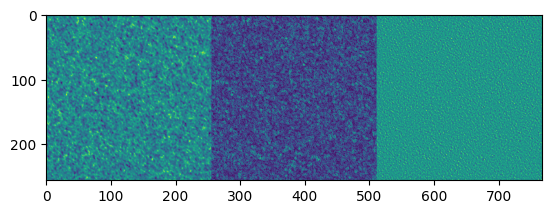

In [22]:
device = cfg['device']

losses = []

total_steps = cfg['total_steps']
steps_til_summary = cfg['steps_til_summary']

total_params = count_parameters(model)


optim = torch.optim.Adam(lr=cfg['lr'], params=parameters)

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)

for step in range(total_steps):
    coords = model_input
    coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
    encoded_input = encode(coords)

    h1, layer1_acts = splitlayer_forward(encoded_input, W1, b1)
    h2, layer2_acts = splitlayer_forward(h1, W2, b2)
    model_output, layer3_acts = splitlayer_forward(h2, W3, b3)

    mse, psnr = mse_and_psnr(model_output, ground_truth)
    loss = mse

    if cfg.get('use_wandb'):
        wandb.log({'step': step, 'mse': mse.item(), 'psnr': psnr.item()})

    if not step % steps_til_summary:
        print(f"Step {step}: psnr={psnr:0.6f} mse={loss:0.6f}")
        img_grad_tensor = gradient(model_output, coords)
        img_laplacian_tensor = laplace(model_output, coords)

        img = imagify_tensor(model_output)
        img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
        img_laplacian = imagify_tensor(img_laplacian_tensor)

        colage = tensor2pil(torch.cat([img, img_grad, img_laplacian], dim=1))
        plt.imshow(colage)
        plt.show()

        if cfg.get('use_wandb'):
            wandb.log({'step': step, 'image': wandb.Image(colage)})

    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss.item())
    break

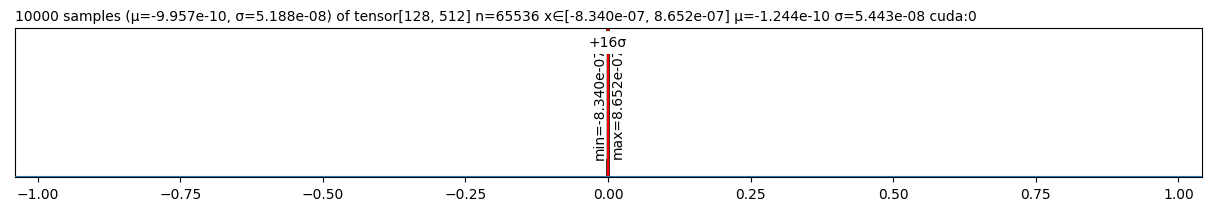

In [23]:
W1.grad.plt

In [24]:
for p in parameters:
    g = p.grad
    print(f'g.shape={g.shape} g.mean={g.mean():.4E} g.gtd={g.std():.4E}')
    # display(p.grad.plt)

g.shape=torch.Size([128, 512]) g.mean=-1.2443E-10 g.gtd=5.4434E-08
g.shape=torch.Size([512]) g.mean=4.1111E-09 g.gtd=1.2120E-07
g.shape=torch.Size([128, 512]) g.mean=-2.7533E-11 g.gtd=4.2995E-08
g.shape=torch.Size([512]) g.mean=2.0193E-08 g.gtd=1.0071E-06
g.shape=torch.Size([128, 4]) g.mean=1.8785E-09 g.gtd=7.7678E-07
g.shape=torch.Size([4]) g.mean=-2.2754E-04 g.gtd=5.4114E-04


In [25]:
break

SyntaxError: 'break' outside loop (668683560.py, line 4)

In [ ]:
F.mse_loss(ground_truth, model_output)

In [ ]:
F.mse_loss(ground_truth, torch.zeros_like(ground_truth))

In [ ]:
ground_truth.plt

In [ ]:
model_output.plt

In [ ]:
hpreact, hpreact_tanh, hpreact_sigmoid, hpreact_sin, hpreact_cos, htanh, hsigmoid, hsin, hcos = layer1_acts['internal_activations']


In [ ]:
legends = []

for i, layer_acts in enumerate([layer1_acts, layer2_acts, layer3_acts]):
    hpreact, hpreact_tanh, hpreact_sigmoid, hpreact_sin, hpreact_cos, htanh, hsigmoid, hsin, hcos = layer_acts['internal_activations']

    hy, hx = torch.histogram(htanh.detach().cpu(), density=True)
    plt.plot(hx[:-1], hy)
    legends.append(f'layer{i+1}')
    
    print(f'layer{i+1} {(htanh.abs() > 0.99).float().mean()*100:.2f}% tanh saturated')
    display(htanh.plt)
    
plt.legend(legends);
plt.title('activation distribution (tanh)')

In [ ]:
legends = []

for i, layer_acts in enumerate([layer1_acts, layer2_acts, layer3_acts]):
    hpreact, hpreact_tanh, hpreact_sigmoid, hpreact_sin, hpreact_cos, htanh, hsigmoid, hsin, hcos = layer_acts['internal_activations']

    hy, hx = torch.histogram(hsigmoid.detach().cpu(), density=True)
    plt.plot(hx[:-1], hy)
    legends.append(f'layer{i+1}')
    
    print(f'layer{i+1} {(((hsigmoid-0.5)*2).abs() > 0.98).float().mean()*100:.2f}% sigmoid saturated')
    display(hsigmoid.plt)
    
plt.legend(legends);
plt.title('activation distribution (hsigmoid)')

In [ ]:
legends = []

for i, layer_acts in enumerate([layer1_acts, layer2_acts, layer3_acts]):
    hpreact, hpreact_tanh, hpreact_sigmoid, hpreact_sin, hpreact_cos, htanh, hsigmoid, hsin, hcos = layer_acts['internal_activations']

    hy, hx = torch.histogram(hsin.detach().cpu(), density=True)
    plt.plot(hx[:-1], hy)
    legends.append(f'layer{i+1}')
    
    # print(f'layer{i+1} {(((hsigmoid-0.5)*2).abs() > 0.98).float().mean()*100:.2f}% sigmoid saturated')
    display(hsin.plt)
    
plt.legend(legends);
plt.title('activation distribution (hsin)')

In [ ]:
legends = []

for i, layer_acts in enumerate([layer1_acts, layer2_acts, layer3_acts]):
    hpreact, hpreact_tanh, hpreact_sigmoid, hpreact_sin, hpreact_cos, htanh, hsigmoid, hsin, hcos = layer_acts['internal_activations']

    hy, hx = torch.histogram(hcos.detach().cpu(), density=True)
    plt.plot(hx[:-1], hy)
    legends.append(f'layer{i+1}')
    
    # print(f'layer{i+1} {(((hsigmoid-0.5)*2).abs() > 0.98).float().mean()*100:.2f}% sigmoid saturated')
    display(hcos.plt)
    
plt.legend(legends);
plt.title('activation distribution (hcos)')

In [ ]:
hpreact_sigmoid.plt

In [ ]:
print(f'{(htanh.abs() > 0.99).float().mean()*100:.2f}% tanh saturated')
htanh.plt

In [ ]:
print(f'{(((hsigmoid-0.5)*2).abs() > 0.98).float().mean()*100:.2f}% hsigmoid saturated')
hsigmoid.plt

In [ ]:
hpreact.plt

In [ ]:
break

## Basic distributinos 

First, lets look at the activations and the pre-activations

### Linear

In [ ]:
in_h = 128
out_h = 64
batch_size = 1024

In [ ]:
in_uniform = torch.rand(batch_size, in_h)
in_normal = torch.randn(batch_size, in_h)

in_ones = torch.ones(batch_size, in_h)

In [ ]:
layer0 = nn.Linear(in_h, out_h)
layer0.weight

In [ ]:
layer0.weight[0]

In [ ]:
layer0.weight.plt

In [ ]:
layer0.bias.plt

In [ ]:
(in_ones@layer0.weight.T + layer0.bias).plt

In [ ]:
layer0(in_ones).plt

In [ ]:
layer0(in_uniform).plt

In [ ]:
in_normal.plt

In [ ]:
layer0(in_normal).plt

In [ ]:
layer0(in_normal).tanh().plt

In [ ]:
layer0(in_normal).sigmoid().plt

In [ ]:
layer0(in_normal).sin().plt

In [ ]:
layer0(in_normal).cos().plt

In [ ]:
layer0(in_normal).sin().cos().plt

In [ ]:
layer0(in_normal).cos().sin().plt

## tanh

In [ ]:
in_h

In [ ]:
layer0(in_uniform).plt

In [ ]:
layer0(in_uniform).tanh().plt

## sin

We have:


- x ~ U(-1, 1)
- y = sin(ax + b)

One dimensional case.




In [ ]:
x = (torch.rand(1000) - 0.5)*2.
x.plt

In [ ]:
a = torch.rand_like(x) + 20.
(a*x).sin().plt

In [ ]:
x.cos().plt()

# Chaos zone

In [ ]:
cameraman.pil_img

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_posenc_micro_128'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 128,
    'hidden_layers': 1,
    'encoded_size': 64,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNetWithEncoding(**cfg['model_kwargs'])
count_parameters(model)

In [ ]:
# cfg['model_kwargs'] = {
#     'in_features': 2,
#     'out_features': 1,
#     'hidden_features': 256,
#     'hidden_layers': 3,
#     'outermost_linear': True,
# }


# seed_all(cfg.get('seed', 0))
# model = Siren(**cfg['model_kwargs'])

In [ ]:
device = cfg['device']
model.to(device)

losses = []

total_steps = cfg['total_steps']
steps_til_summary = cfg['steps_til_summary']

total_params = count_parameters(model)


optim = torch.optim.Adam(lr=cfg['lr'], params=model.parameters())

model_input, ground_truth = next(iter(dataloader))
model_input, ground_truth = model_input.to(device), ground_truth.to(device)

In [ ]:
ground_truth.plt

In [ ]:
break

In [ ]:
model_output, coords = model(model_input)
mse, psnr = mse_and_psnr(model_output, ground_truth)

In [ ]:
model_output.plt

In [ ]:
mse.backward()

In [ ]:
for name, p in model.named_parameters():
    print(name, f'mean={p.grad.mean():.2e} std={p.grad.std():.2e}')
    # display(p.grad)

In [ ]:
for name, p in model.named_parameters():
    print(name, f'mean={p.grad.mean():.2e} std={p.grad.std():.2e}')
    display(p.grad.plt)

In [ ]:
class UberLayer(nn.Module):
    def __init__(self, input_dim, h=32):
        super().__init__()
        self.linear = nn.Linear(input_dim, h*4)
        self.h = h
        
    def forward(self, x):
        h = self.h
        o = self.linear(x)
        o = o[..., :h].sigmoid() * o[..., h:2*h].tanh() * o[..., 2*h:3*h].sin() * o[..., 3*h:4*h].cos()
        return o

In [ ]:
model_input.plt

In [ ]:
i = model.encoding(model_input)
i.plt

In [ ]:
torch.ones_like(i).plt

In [ ]:
model.net[0](torch.ones_like(i)).plt

In [ ]:
nn.Linear(32, 32)(2*torch.rand(128, 32)).plt

In [ ]:
nn.Linear(32, 32)(2*torch.rand(128, 32)).sigmoid().plt

In [ ]:
nn.Linear(32, 32)(2*torch.rand(128, 32)).sin().plt

In [ ]:
torch.randn(128, 32).plt

In [ ]:
(10*torch.randn(128, 32)).sin().plt

In [ ]:
(10*torch.randn(128, 32)).cos().plt

In [ ]:
torch.randn(128, 32).cos().plt

In [ ]:
nn.Linear(32, 32)(torch.randn(128, 32)).cos().plt

In [ ]:
nn.Linear(32, 32)(2*torch.rand(128, 32)).tanh().plt

In [ ]:
model.net[0](i).plt

In [ ]:
F.mse_loss(model_output, ground_truth)

In [ ]:
((torch.rand_like(ground_truth) * 2)-1).plt

In [ ]:
(0.1*torch.randn_like(ground_truth)).plt

In [ ]:
F.mse_loss(0.1*torch.randn_like(ground_truth), ground_truth)

In [ ]:
model_output.plt

In [ ]:
mse

In [ ]:
for step in range(total_steps):
    model_output, coords = model(model_input)
    mse, psnr = mse_and_psnr(model_output, ground_truth)
    loss = mse

    if cfg.get('use_wandb'):
        wandb.log({'step': step, 'mse': mse.item(), 'psnr': psnr.item()})

    if not step % steps_til_summary:
        print(f"Step {step}, Total loss {loss:0.6f}")
        img_grad_tensor = gradient(model_output, coords)
        img_laplacian_tensor = laplace(model_output, coords)

        img = imagify_tensor(model_output)
        img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
        img_laplacian = imagify_tensor(img_laplacian_tensor)

        colage = tensor2pil(torch.cat([img, img_grad, img_laplacian], dim=1))
        plt.imshow(colage)
        plt.show()

        if cfg.get('use_wandb'):
            wandb.log({'step': step, 'image': wandb.Image(colage)})

    optim.zero_grad()
    loss.backward()
    optim.step()
    losses.append(loss.item())

In [ ]:
def train(model, cfg):
    device = cfg['device']
    model.to(device)
    
    losses = []

    total_steps = cfg['total_steps']
    steps_til_summary = cfg['steps_til_summary']

    if cfg.get('use_wandb'):
        import wandb
        wandb.init(project=cfg['project'], name=cfg['experiment_name'], config=cfg)
        
    total_params = count_parameters(model)

    if cfg.get('use_wandb'):
        wandb.log({'total_params': total_params})

    optim = torch.optim.Adam(lr=cfg['lr'], params=model.parameters())

    model_input, ground_truth = next(iter(dataloader))
    model_input, ground_truth = model_input.to(device), ground_truth.to(device)

    for step in range(total_steps):
        model_output, coords = model(model_input)
        mse, psnr = mse_and_psnr(model_output, ground_truth)
        loss = mse

        if cfg.get('use_wandb'):
            wandb.log({'step': step, 'mse': mse.item(), 'psnr': psnr.item()})

        if not step % steps_til_summary:
            print(f"Step {step}, Total loss {loss:0.6f}")
            img_grad_tensor = gradient(model_output, coords)
            img_laplacian_tensor = laplace(model_output, coords)

            img = imagify_tensor(model_output)
            img_grad = imagify_tensor(img_grad_tensor.norm(dim=-1))
            img_laplacian = imagify_tensor(img_laplacian_tensor)

            colage = tensor2pil(torch.cat([img, img_grad, img_laplacian], dim=1))
            plt.imshow(colage)
            plt.show()

            if cfg.get('use_wandb'):
                wandb.log({'step': step, 'image': wandb.Image(colage)})

        optim.zero_grad()
        loss.backward()
        optim.step()
        losses.append(loss.item())

    wandb.finish()

In [ ]:
break

# SIREN

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4

cfg['total_steps'] = 500
cfg['steps_til_summary'] = 100
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'siren_baseline'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 256,
    'hidden_layers': 3,
    'outermost_linear': True,
}


seed_all(cfg.get('seed', 0))
model = Siren(**cfg['model_kwargs'])
train(model, cfg)

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'siren_baseline'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 256,
    'hidden_layers': 3,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = Siren(**cfg['model_kwargs'])
train(model, cfg)

In [ ]:
class SineLayer(nn.Module):
    # See paper sec. 3.2, final paragraph, and supplement Sec. 1.5 for discussion of omega_0.
    
    # If is_first=True, omega_0 is a frequency factor which simply multiplies the activations before the 
    # nonlinearity. Different signals may require different omega_0 in the first layer - this is a 
    # hyperparameter.
    
    # If is_first=False, then the weights will be divided by omega_0 so as to keep the magnitude of 
    # activations constant, but boost gradients to the weight matrix (see supplement Sec. 1.5)
    
    def __init__(self, in_features, out_features, bias=True,
                 is_first=False, omega_0=30):
        super().__init__()
        self.omega_0 = omega_0
        self.is_first = is_first
        
        self.in_features = in_features
        self.linear = nn.Linear(in_features, out_features, bias=bias)
        
        # self.init_weights()
    
    def init_weights(self):
        with torch.no_grad():
            if self.is_first:
                self.linear.weight.uniform_(-1 / self.in_features, 
                                             1 / self.in_features)      
            else:
                self.linear.weight.uniform_(-np.sqrt(6 / self.in_features) / self.omega_0, 
                                             np.sqrt(6 / self.in_features) / self.omega_0)
        
    def forward(self, input):
        return torch.sin(self.omega_0 * self.linear(input))
    
    def forward_with_intermediate(self, input): 
        # For visualization of activation distributions
        intermediate = self.omega_0 * self.linear(input)
        return torch.sin(intermediate), intermediate
    
    
class Siren(nn.Module):
    def __init__(self, in_features, hidden_features, hidden_layers, out_features, outermost_linear=False, 
                 first_omega_0=30, hidden_omega_0=30.):
        super().__init__()
        
        self.net = []
        self.net.append(SineLayer(in_features, hidden_features, 
                                  is_first=True, omega_0=first_omega_0))

        for i in range(hidden_layers):
            self.net.append(SineLayer(hidden_features, hidden_features, 
                                      is_first=False, omega_0=hidden_omega_0))

        if outermost_linear:
            final_linear = nn.Linear(hidden_features, out_features)
            
            with torch.no_grad():
                final_linear.weight.uniform_(-np.sqrt(6 / hidden_features) / hidden_omega_0, 
                                              np.sqrt(6 / hidden_features) / hidden_omega_0)
                
            self.net.append(final_linear)
        else:
            self.net.append(SineLayer(hidden_features, out_features, 
                                      is_first=False, omega_0=hidden_omega_0))
        
        self.net = nn.Sequential(*self.net)
    
    def forward(self, coords):
        coords = coords.clone().detach().requires_grad_(True) # allows to take derivative w.r.t. input
        output = self.net(coords)
        return output, coords        

    def forward_with_activations(self, coords, retain_grad=False):
        '''Returns not only model output, but also intermediate activations.
        Only used for visualizing activations later!'''
        activations = OrderedDict()

        activation_count = 0
        x = coords.clone().detach().requires_grad_(True)
        activations['input'] = x
        for i, layer in enumerate(self.net):
            if isinstance(layer, SineLayer):
                x, intermed = layer.forward_with_intermediate(x)
                
                if retain_grad:
                    x.retain_grad()
                    intermed.retain_grad()
                    
                activations['_'.join((str(layer.__class__), "%d" % activation_count))] = intermed
                activation_count += 1
            else: 
                x = layer(x)
                
                if retain_grad:
                    x.retain_grad()
                    
            activations['_'.join((str(layer.__class__), "%d" % activation_count))] = x
            activation_count += 1

        return activations

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'siren_no_init'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 256,
    'hidden_layers': 3,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = Siren(**cfg['model_kwargs'])
train(model, cfg)

# uber inr

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_baseline'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 32,
    'hidden_layers': 6,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNet(**cfg['model_kwargs'])
train(model, cfg)

In [ ]:


# X = torch.randn((256, 256, 2))


In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_posenc'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 32,
    'hidden_layers': 6,
    'encoded_size': 64,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNetWithEncoding(**cfg['model_kwargs'])
train(model, cfg)

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_posenc'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 64,
    'hidden_layers': 3,
    'encoded_size': 64,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNetWithEncoding(**cfg['model_kwargs'])
train(model, cfg)

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_posenc_micro'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 64,
    'hidden_layers': 1,
    'encoded_size': 64,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNetWithEncoding(**cfg['model_kwargs'])
train(model, cfg)

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_posenc_micro_128'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 128,
    'hidden_layers': 1,
    'encoded_size': 64,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNetWithEncoding(**cfg['model_kwargs'])
count_parameters(model)
breakk()
train(model, cfg)

In [ ]:
cfg = {}
cfg['device'] = 'cuda:3'
cfg['lr'] = 1e-4
cfg['seed'] = 0

cfg['total_steps'] = 10_000
cfg['steps_til_summary'] = 1000
cfg['project'] = 'uber_inr'
cfg['experiment_name'] = 'ubernet_posenc_2_layers'
cfg['use_wandb'] = True

cfg['model_kwargs'] = {
    'in_features': 2,
    'out_features': 1,
    'hidden_features': 128,
    'hidden_layers': 0,
    'encoded_size': 64,
    'outermost_linear': True,
}

seed_all(cfg.get('seed', 0))
model = UberNetWithEncoding(**cfg['model_kwargs'])
count_parameters(model)
breakk()
train(model, cfg)

In [ ]:
import torch
import torch.nn as nn

def print_model_shape(model, input_shape):
    with torch.no_grad():
        model.eval()
        x = torch.rand(input_shape)
        print(f"{'Layer Name':<30} {'Input Shape':<20} {'Output Shape':<20}")
        print("-" * 70)
        for name, layer in model.named_modules():
            if isinstance(layer, nn.Conv2d) or isinstance(layer, nn.Linear):
                x = layer(x)
                print(f"{name:<30} {str(x.shape):<20} {str(x.shape):<20}")

# Example usage
model = nn.Sequential(
    nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
    nn.ReLU(),
    nn.MaxPool2d(kernel_size=2, stride=2),
    nn.Flatten(),
    nn.Linear(512 * 7 * 7, 1024),
    nn.ReLU(),
    nn.Linear(1024, 10)
)

print_model_shape(model, (1, 3, 32, 32))